In [39]:
import requests
import os
import json
import pandas as pd
import geopandas as gpd

In [40]:
high_priority_amenities = [
    'museum',
    'park',
    'beach',
    'viewpoint',
    'monument',
    'historic'
]
tourist_amenities = [
    'restaurant',
    'cafe',
    'bar',
    'pub',
    'theatre',
    'cinema',
    'art_centre',
    'library',
    'zoo',
    'marketplace',
    'attraction',
    'information'
]


all_amenities = high_priority_amenities + tourist_amenities

In [41]:


filename = 'osm_scrape.json'


if os.path.exists(filename):
    
    print('File exists, loading from file')
    with open(filename, 'r') as f:
        pois = json.load(f)

else:
  print('File does not exist, scraping from OSM')
  query = """
  [out:json][timeout:25];
  (
  """

  # Add each amenity to the query
  for amenity in all_amenities:
      query += f'  node["amenity"="{amenity}"](41.702824,-87.921977,42.129745,-87.392660);\n'

  query += """
  );
  out body;
  >;
  out skel qt;
  """
  response = requests.post("https://overpass-api.de/api/interpreter", data=query)
  pois = response.json()


  # save file
  with open (filename, 'w') as f:
    json.dump(pois, f)





File exists, loading from file


In [42]:
# parse json into a df
df = pd.DataFrame(pois['elements'])

# unpack 'tags' column into multiple columns
df = pd.concat([df.drop(['tags'], axis=1), df['tags'].apply(pd.Series)], axis=1)

# Create high priority df and tourist df
high_priority_df = df[df['amenity'].isin(high_priority_amenities)]
tourist_df = df[df['amenity'].isin(tourist_amenities)]


In [43]:
high_priority_df['Tag'].value_counts()

Series([], Name: count, dtype: int64)

In [44]:
# for each column print modal value
for column in df.columns:
    print(column)
    print(df[column].mode())
    print('\n')

type
0    node
Name: type, dtype: object


id
0         271275603
1         306741002
2         308677177
3         310502167
4         311438932
           ...     
4187    11780160052
4188    11780484150
4189    11782507606
4190    11782507620
4191    11786814238
Name: id, Length: 4192, dtype: int64


lat
          lat       lat
0   41.881417  41.89334
1   41.884612       NaN
2   41.890258       NaN
3   41.891310       NaN
4   41.896337       NaN
5   41.902995       NaN
6   41.916211       NaN
7   41.927306       NaN
8   41.931932       NaN
9   41.942307       NaN
10  41.954188       NaN
11  41.961273       NaN
12  41.973162       NaN
13  42.078872       NaN


lon
         lon       lon
0 -87.703576  -87.6242
1 -87.687063       NaN
2 -87.678966       NaN
3 -87.648789       NaN
4 -87.644420       NaN
5 -87.632372       NaN
6 -87.623227       NaN


amenity
0    restaurant
Name: amenity, dtype: object


name
0    Starbucks
Name: name, dtype: object


addr:city
0    Chicago
Name: addr:ci

In [45]:
tourist_df.head()

# return integer of elements in list that are true
lon_idx = [i for i, x in enumerate(tourist_df.columns) if x == 'lon']
lat_idx = [i for i, x in enumerate(tourist_df.columns) if x == 'lat']

print(lat_idx)
print(lon_idx)


# create range of colun indidces    
col_indices = list(range(0, len(tourist_df.columns)))
# remove 142 and 143
col_indices.remove(142)
col_indices.remove(143)

# subset df 
tourist_df = tourist_df.iloc[:, col_indices]


[2, 142]
[3, 143]


<Axes: >

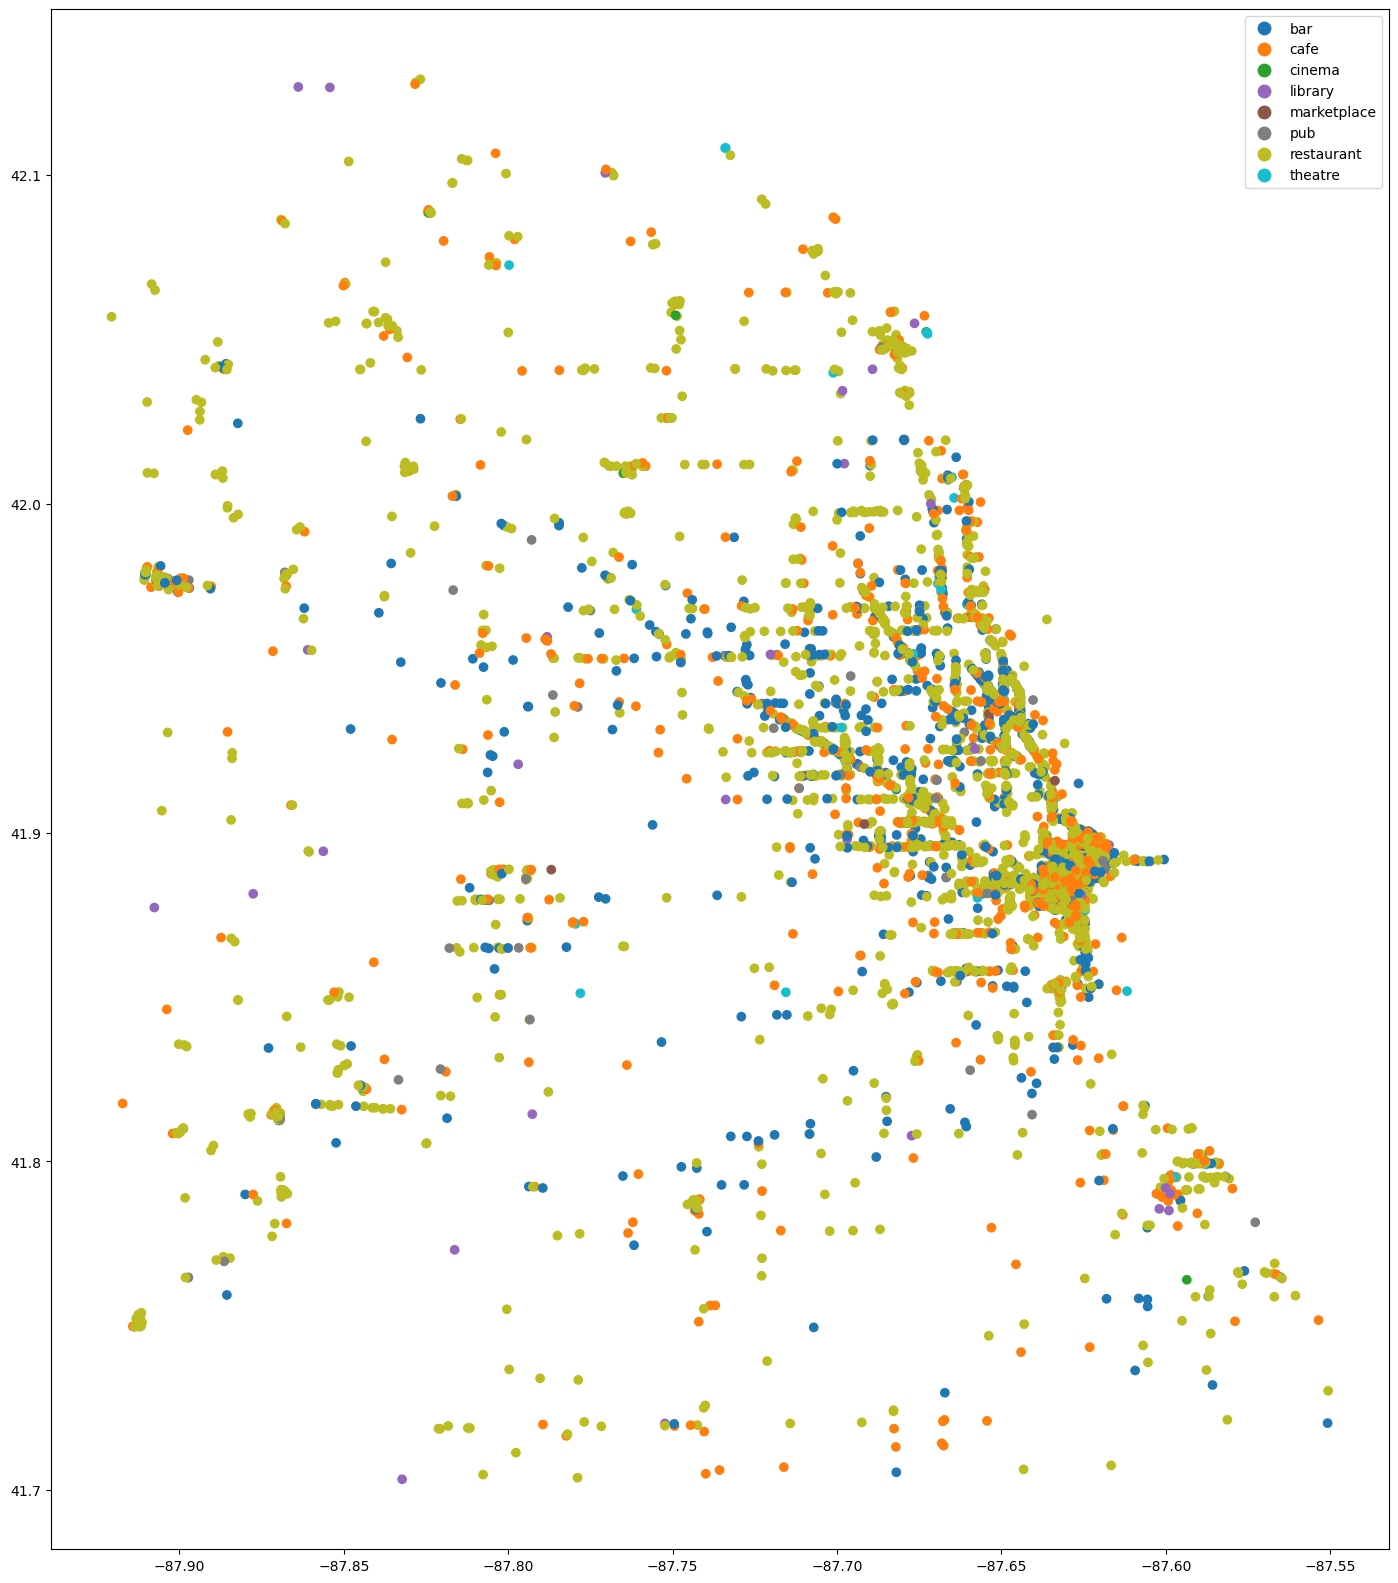

In [46]:

# plot tourist poi with color equal to amenity
tourist_gdf = gpd.GeoDataFrame(tourist_df, geometry=gpd.points_from_xy(tourist_df.lon, tourist_df.lat))

# Plot with color equal to amenity
tourist_gdf.plot(column='amenity', legend=True, figsize=(20, 20))


In [47]:
# pandas show all columns
pd.set_option('display.max_columns', None)

# Create address from columns

tourist_gdf['address'] = tourist_gdf['addr:housenumber'] + ' ' + tourist_gdf['addr:street'] + ', ' + tourist_gdf['addr:city'] + ', ' + tourist_gdf['addr:state'] + ' ' + tourist_gdf['addr:postcode']
tourist_gdf.drop(columns=['addr:housenumber', 'addr:street', 'addr:city', 'addr:state', 'addr:postcode'], inplace=True)


# keep certain columns
keep_cols = [  'id', 'name','amenity', 'address', 'website', 'phone', 'opening_hours', 'geometry', 'lat', 'lon']

tourist_gdf = tourist_gdf[keep_cols]

# Show rows where address is null
tourist_gdf.head()

,id,name,amenity,address,website,phone,opening_hours,geometry,lat,lon
0,271275603,Storefront Theater,theatre,NaN,NaN,NaN,NaN,POINT (-87.62551 41.88481),41.884812,-87.625510
1,306741002,Bubba Gump Shrimp Company,restaurant,"600 East Grand Avenue, Chicago, IL 60611",NaN,NaN,NaN,POINT (-87.60966 41.89141),41.891411,-87.609658
2,308677177,Branko's Submarines,restaurant,NaN,NaN,NaN,NaN,POINT (-87.65686 41.92544),41.925440,-87.656857
3,310502167,Starbucks,cafe,"5001 West Dempster Street, Skokie, IL 60077",NaN,NaN,NaN,POINT (-87.75188 42.04049),42.040490,-87.751878
4,311438932,Neofuturists,theatre,NaN,https://neofuturists.org/,NaN,NaN,POINT (-87.66933 41.97579),41.975795,-87.669332


In [48]:
# make dir for shapefile
if not os.path.exists('OSM_tourist_poi'):
    os.makedirs('OSM_tourist_poi')

# Save to shape file
tourist_gdf.to_file("OSM_tourist_poi/tourist_poi.shp")

/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_45363/121480304.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tourist_gdf.to_file("OSM_tourist_poi/tourist_poi.shp")
